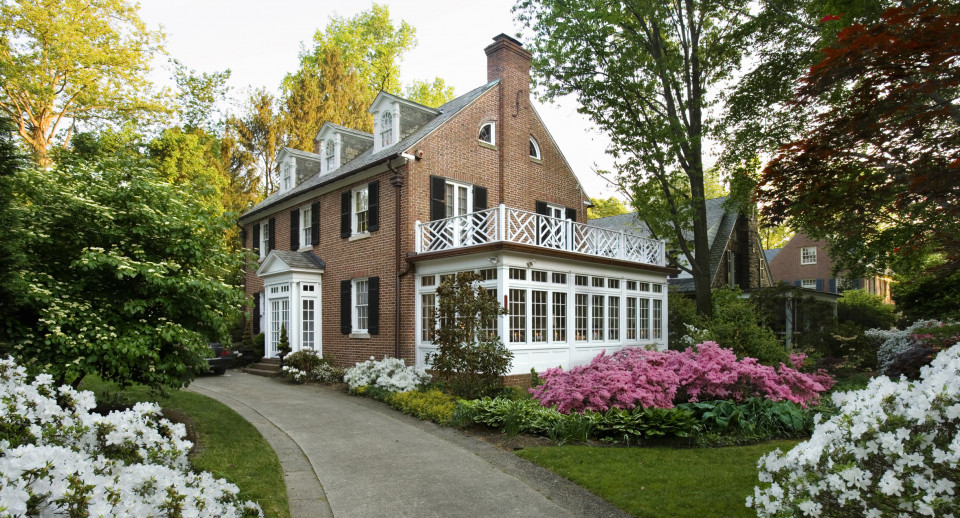

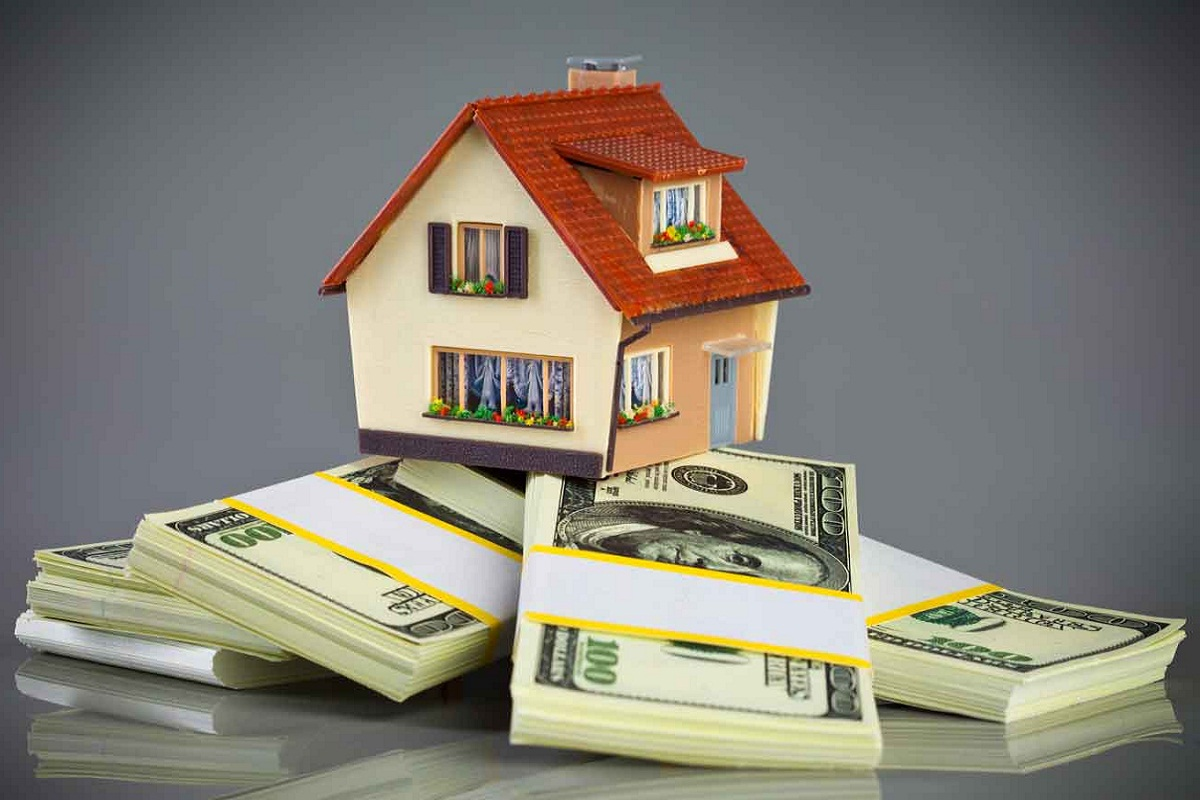

## THE GOAL

* **This notebook shares a study and explaines advanced regression techniques used to predict house prices.**

* **Each feature of the dataset represents a different attribute of each house**
 
* **The goal is to predict the values for SalePrice feature by applying advanced regression models**

## THE METHOD

* **Cross Validation: Using 5-fold cross-validation**

* **4 different advanced regression models were used to predict house prices. Models were XGBoost, LightGBM, Gradient Boosting, Random Forest**

* **Root Mean Squared Error (RMSE) was used as the metric to evaluate the models success**

## IMPORTING PACKAGES AND DATASETS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## EXPLORATORY DATA ANALYSIS

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


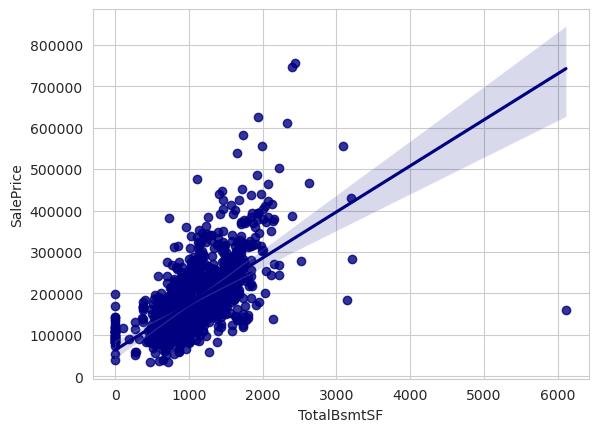

In [6]:
sns.regplot(x = 'TotalBsmtSF', y = 'SalePrice', color = 'navy', data = train)
plt.show()

#### **A linear relationship seems to be between TotalBsmtSF and SalePrice features**

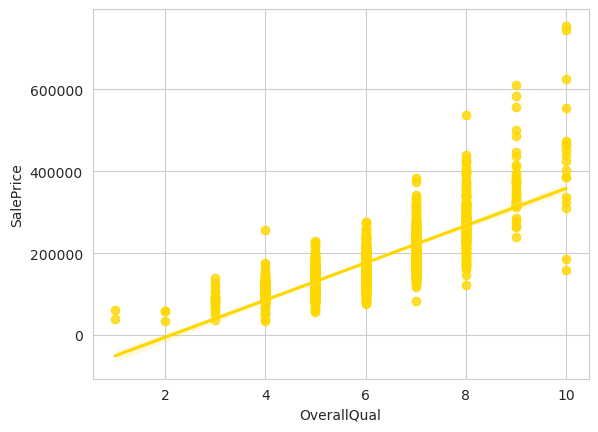

In [7]:
sns.regplot(x = 'OverallQual', y = 'SalePrice', color = 'gold', data = train)
plt.show()

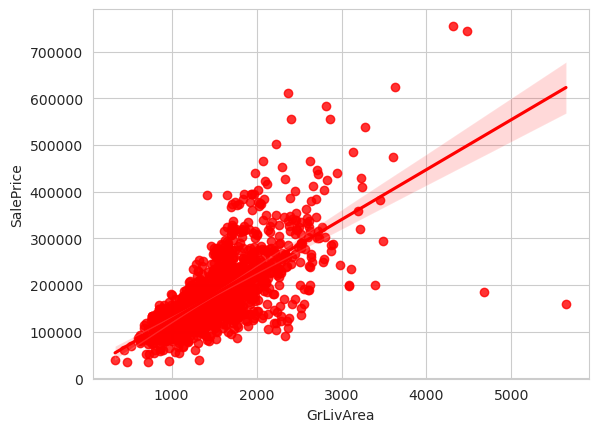

In [8]:
sns.regplot(x = 'GrLivArea', y = 'SalePrice', color = 'red', data = train)
plt.show()

#### **A linear relationship seems to be between GrLivArea and SalePrice features**

In [9]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

<AxesSubplot:>

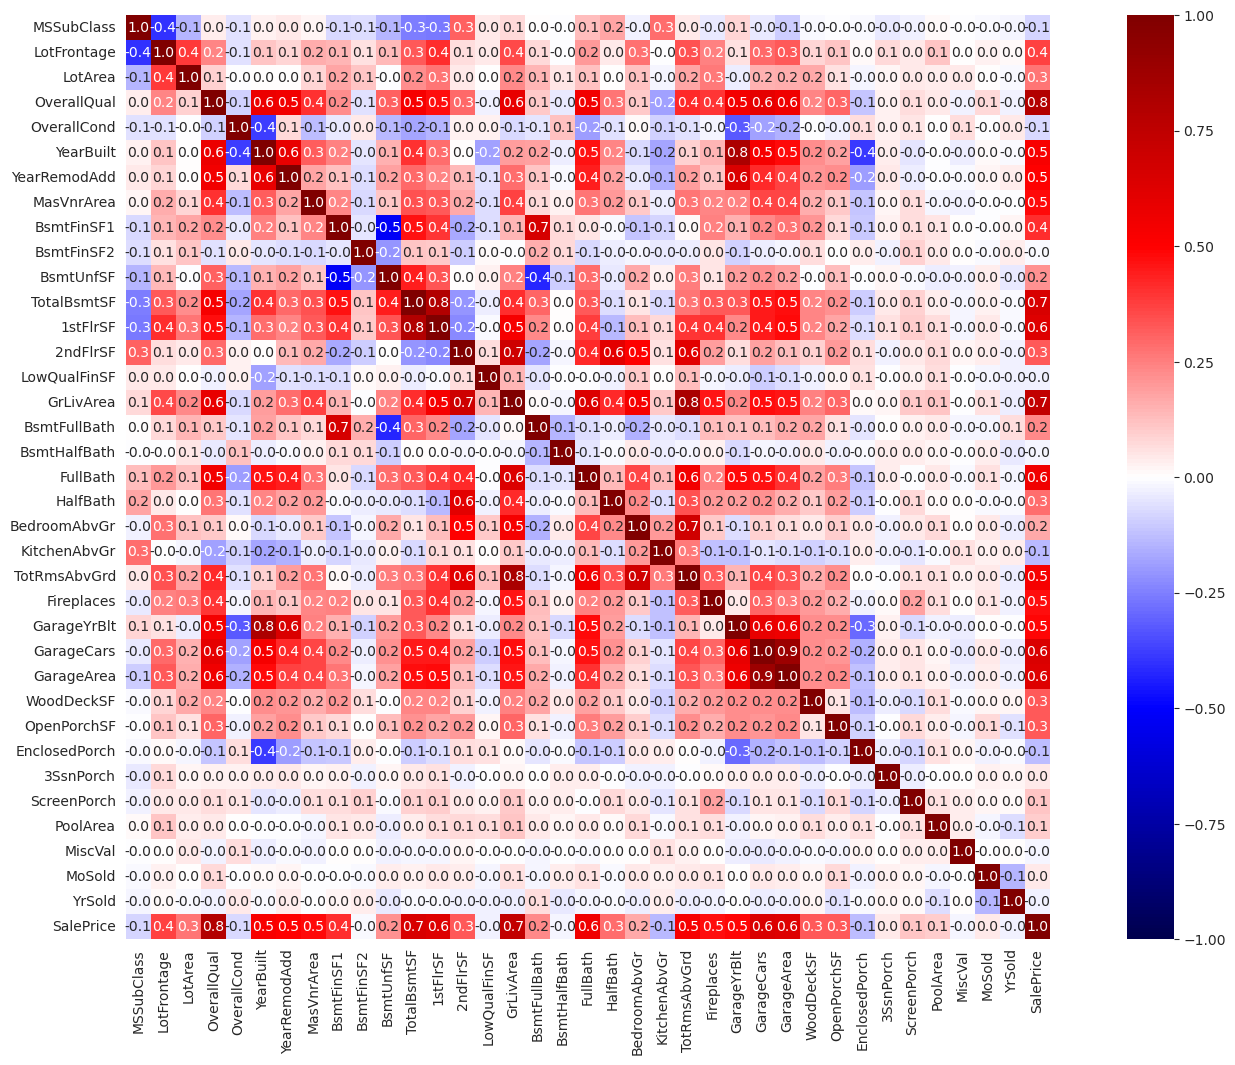

In [10]:
plt.subplots(figsize=(20,12))
sns.heatmap(train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.1f',square = True)

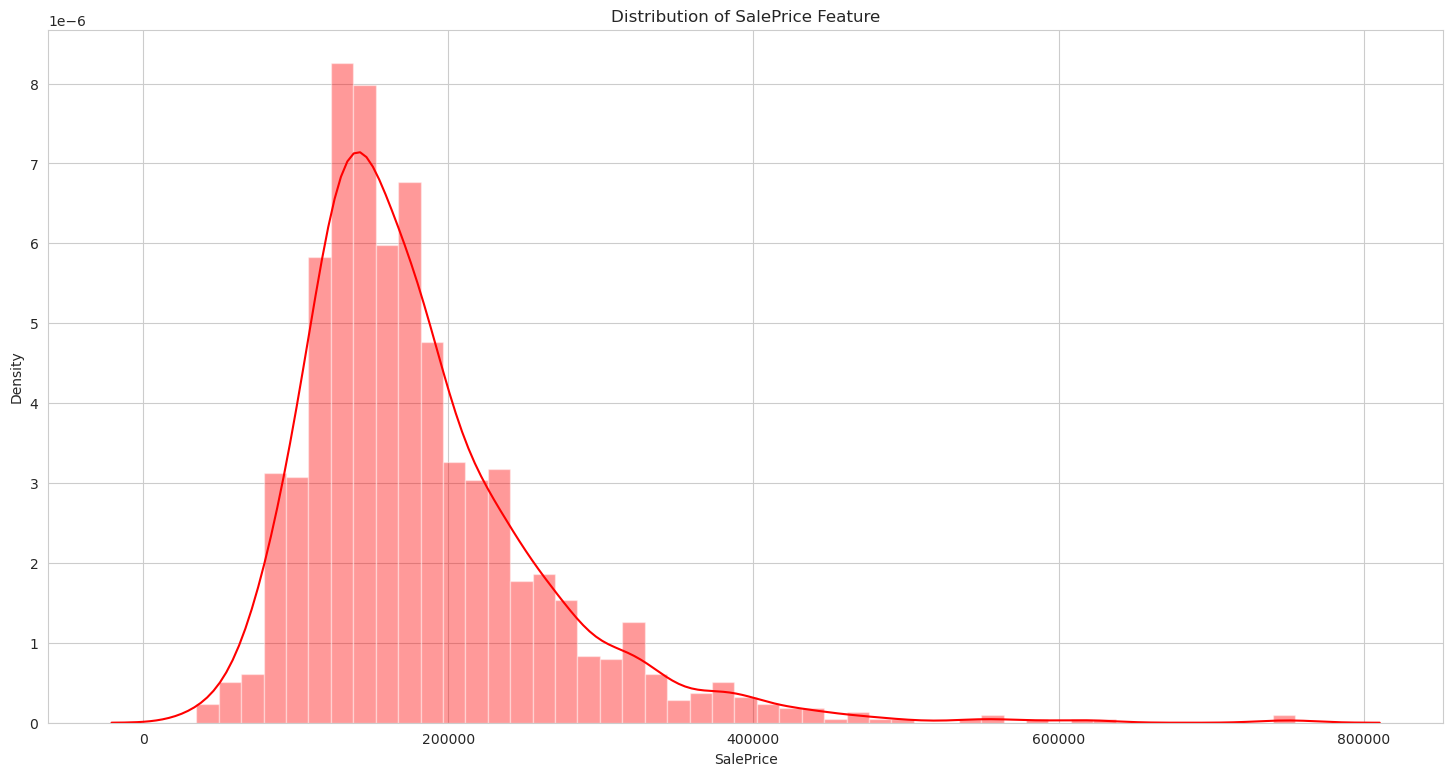

In [11]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['SalePrice'], color="red")
ax.set(xlabel="SalePrice")
ax.set(title="Distribution of SalePrice Feature")
plt.show()

#### **The distribution of the SalePrice feature seems not like Normal Distribution. To convert the distribution of the SalePrice Feature to Normal Distribution, np.log1p transformation function in numpy was applied**

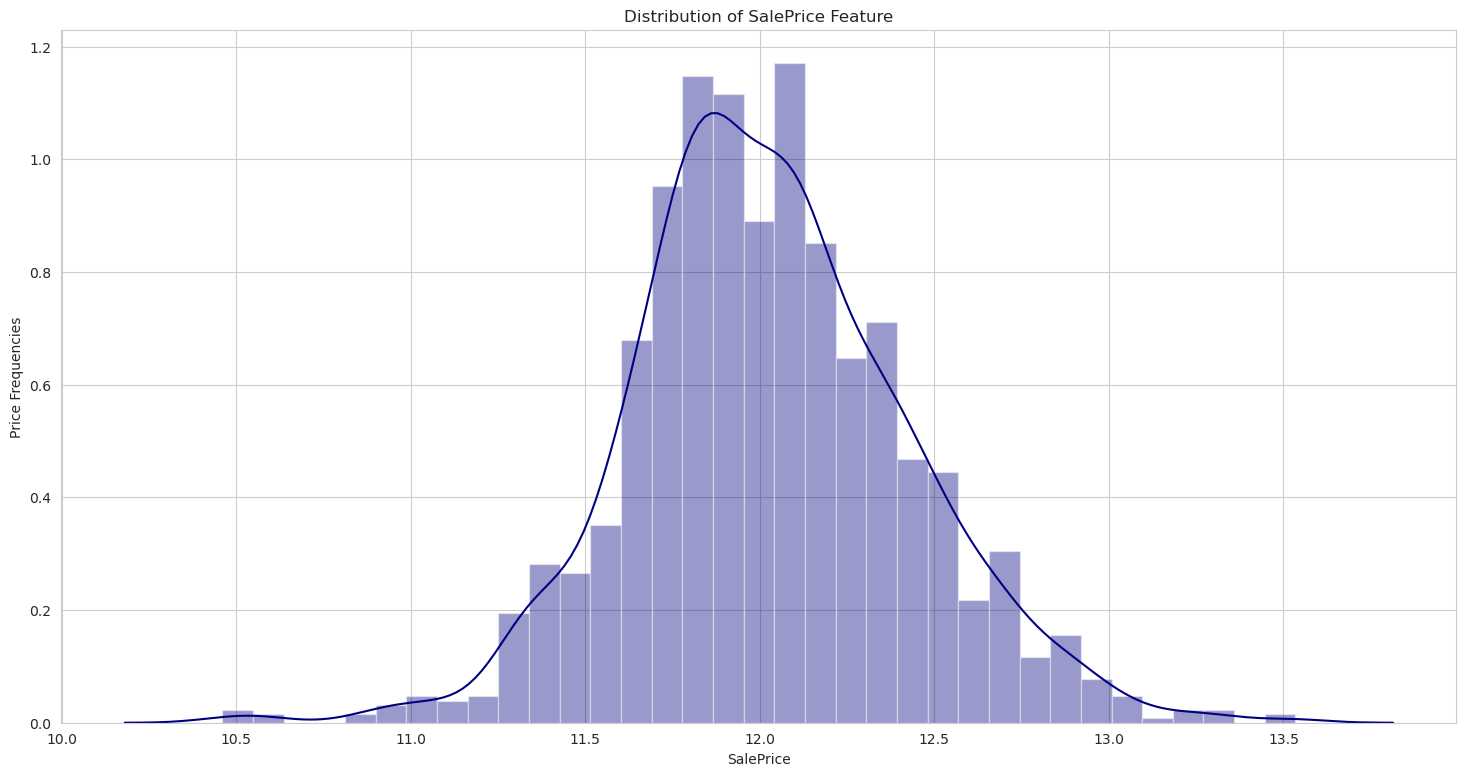

In [12]:
train['SalePrice'] = np.log1p(train['SalePrice'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['SalePrice'], color="navy")
ax.set(ylabel="Price Frequencies")
ax.set(xlabel="SalePrice")
ax.set(title="Distribution of SalePrice Feature")
plt.show()

#### **Now the distribution of the SalePrice feature is much more fitted for Normal Distribution**

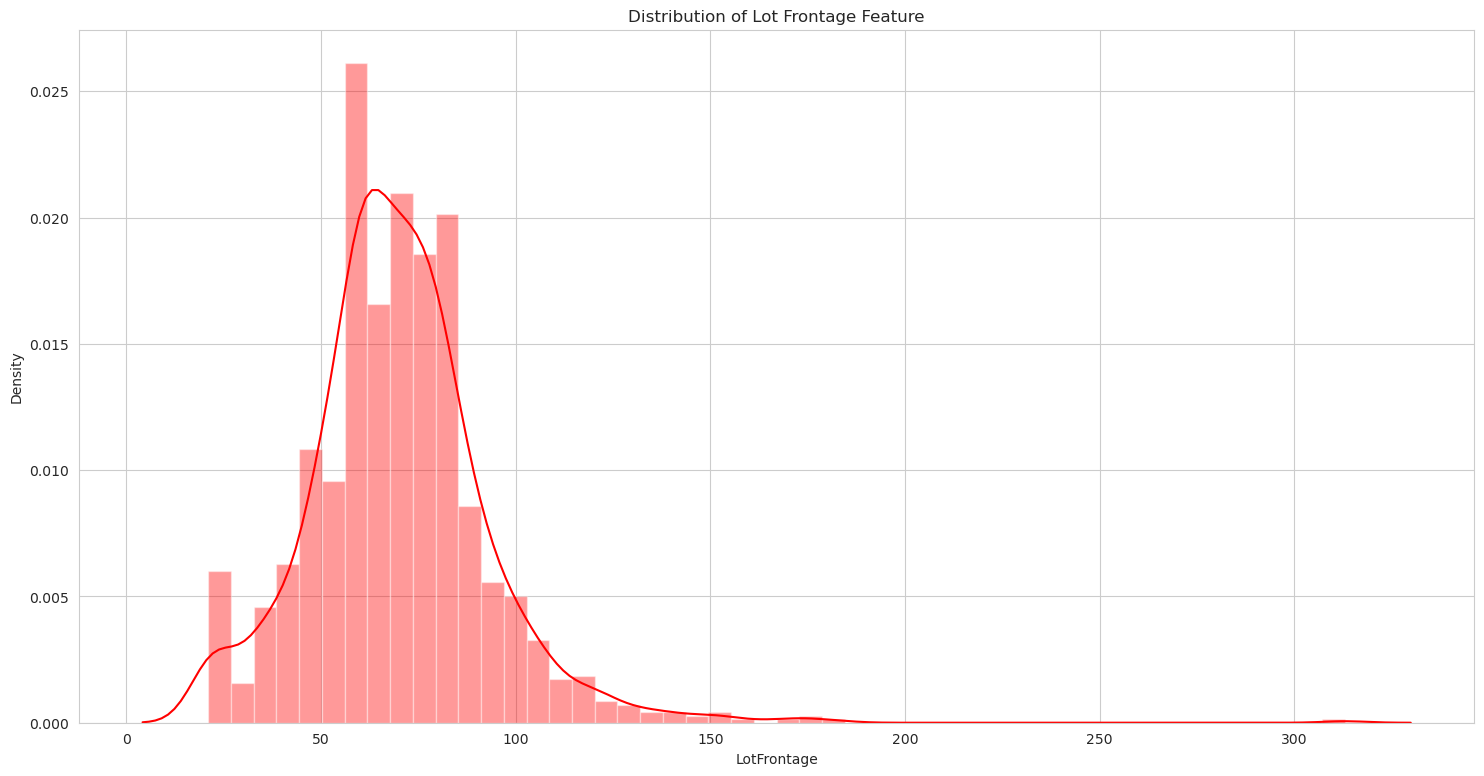

In [13]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotFrontage'], color="red")
ax.set(xlabel="LotFrontage")
ax.set(title="Distribution of Lot Frontage Feature")
plt.show()

#### **The distribution of the LotFrontage feature seems not like Normal Distribution. To convert the distribution of the LotFrontage Feature to Normal Distribution, np.log1p transformation function in numpy was applied**

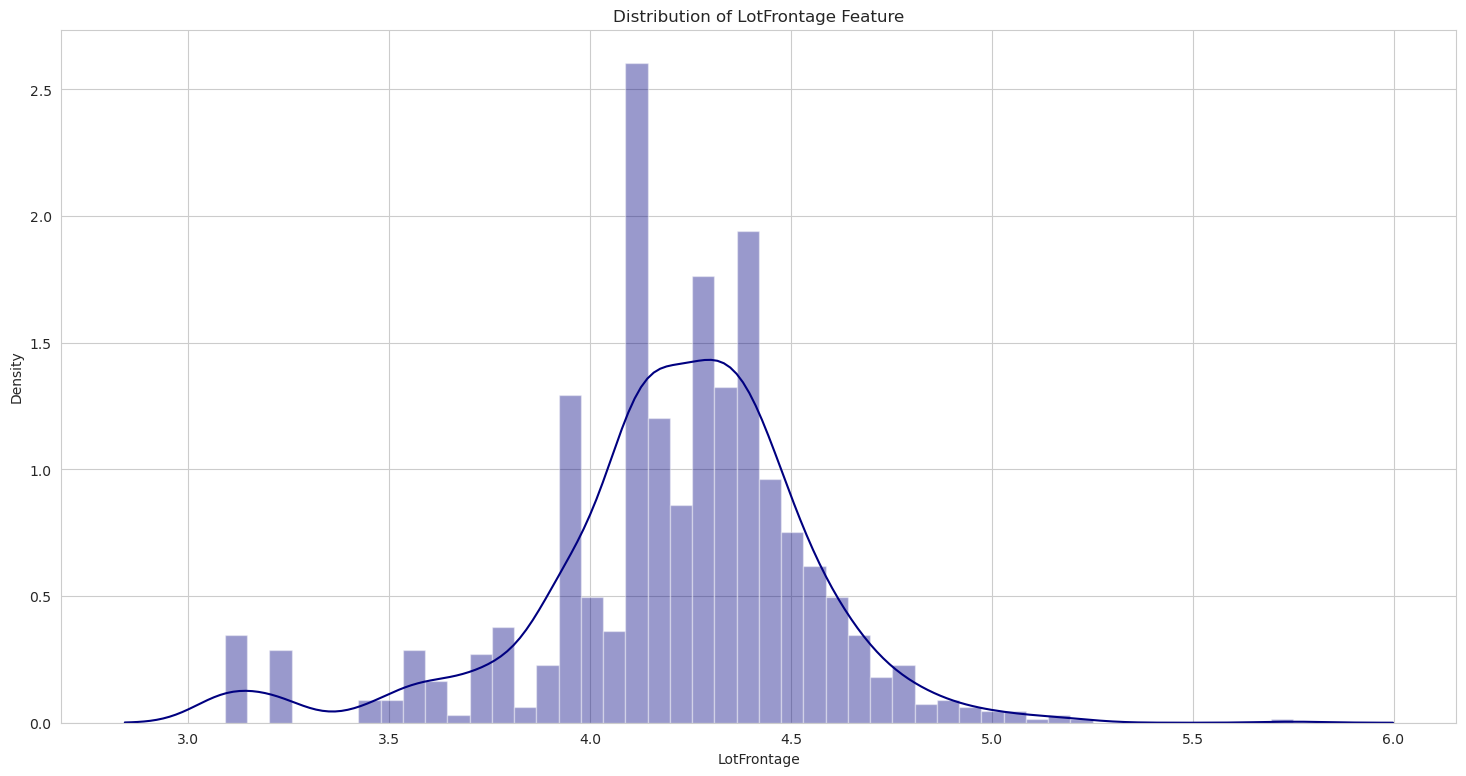

In [14]:
train['LotFrontage'] = np.log1p(train['LotFrontage'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotFrontage'], color="navy")
ax.set(xlabel="LotFrontage")
ax.set(title="Distribution of LotFrontage Feature")
plt.show()

#### **Now the distribution of the LotFrontage feature is much more fitted for Normal Distribution**

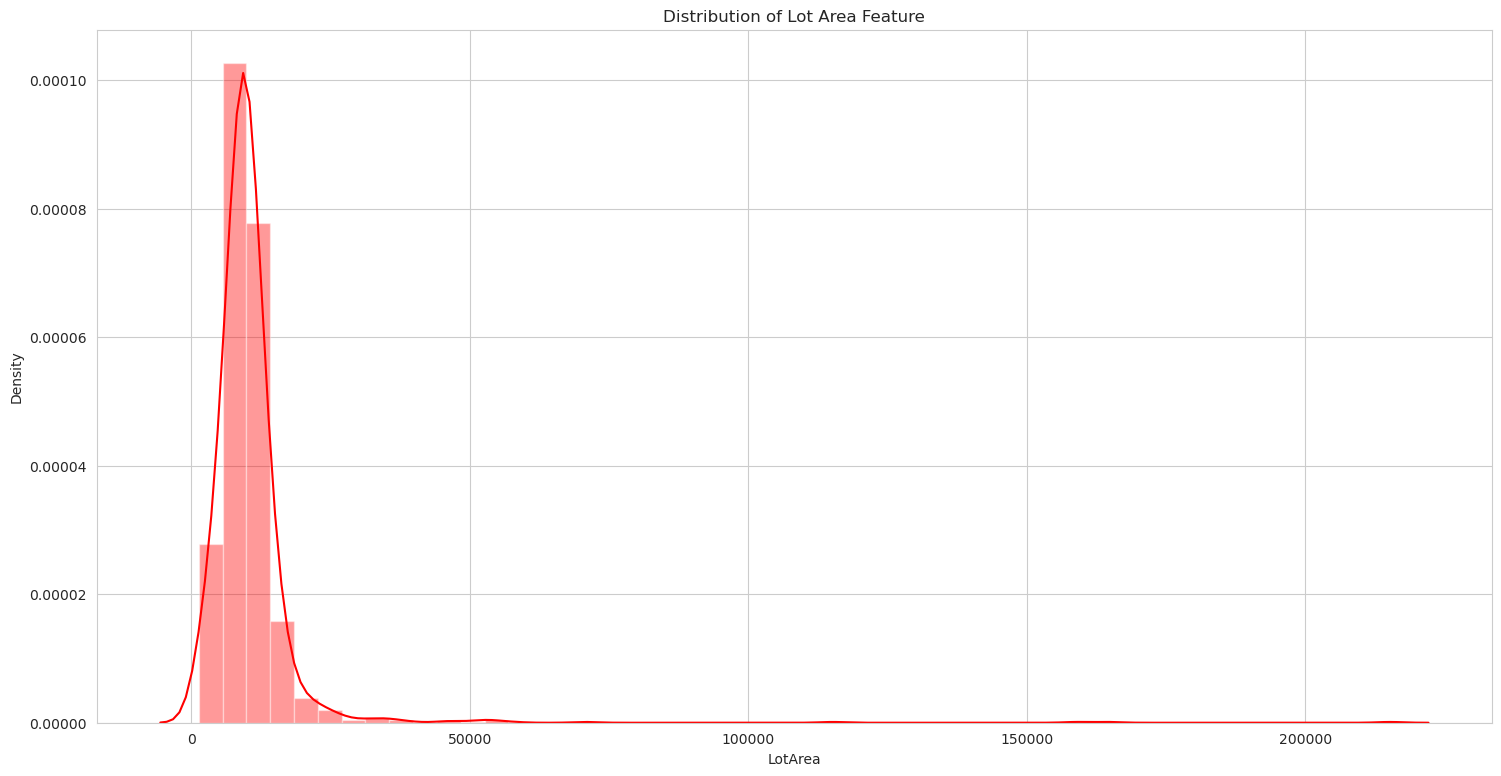

In [15]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotArea'], color="red")
ax.set(xlabel="LotArea")
ax.set(title="Distribution of Lot Area Feature")
plt.show()

#### **The distribution of the LotArea feature seems not like Normal Distribution. To convert the distribution of the LotArea Feature to Normal Distribution, np.log1p transformation function in numpy was applied**

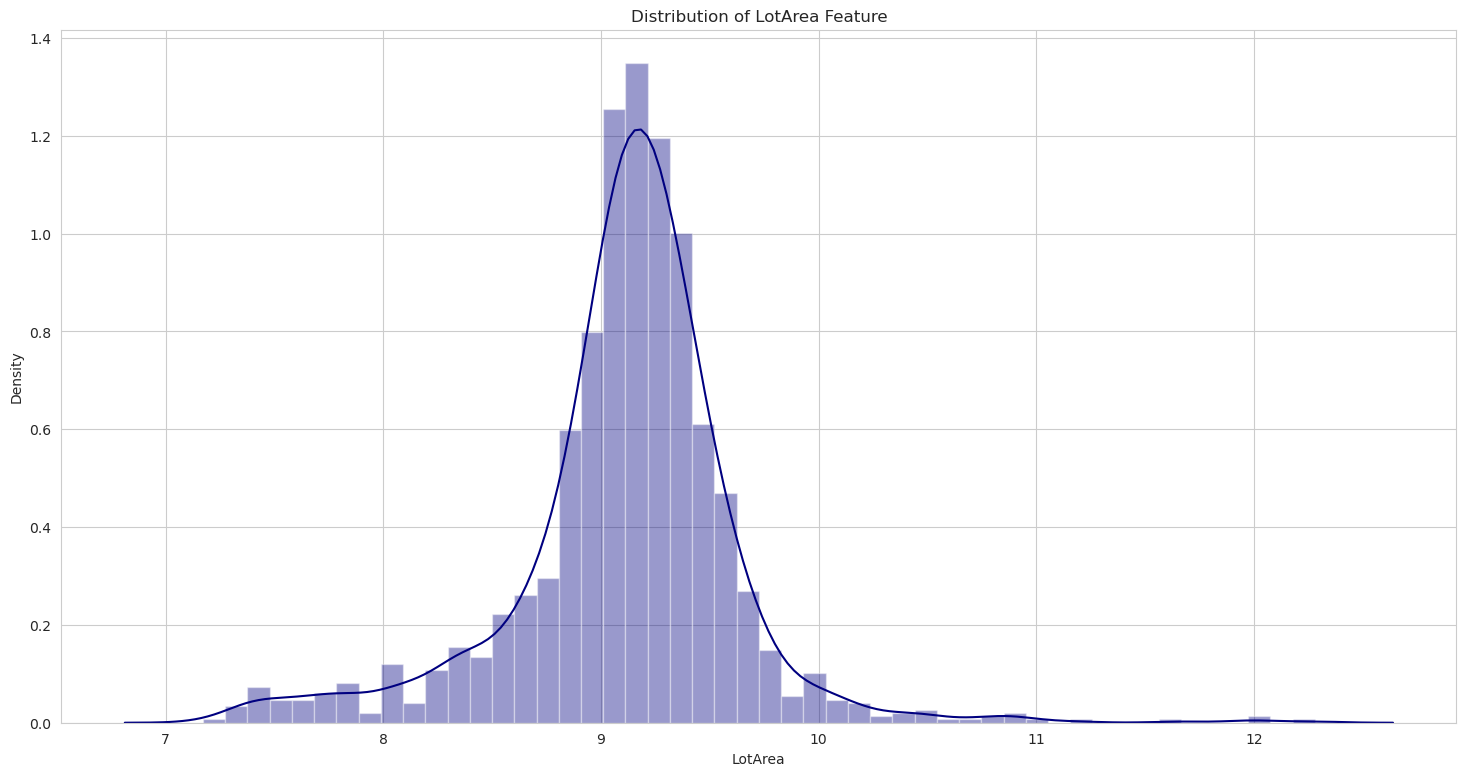

In [16]:
train['LotArea'] = np.log1p(train['LotArea'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotArea'], color="navy")
ax.set(xlabel="LotArea")
ax.set(title="Distribution of LotArea Feature")
plt.show()

#### **Now the distribution of the LotArea feature is much more fitted for Normal Distribution**

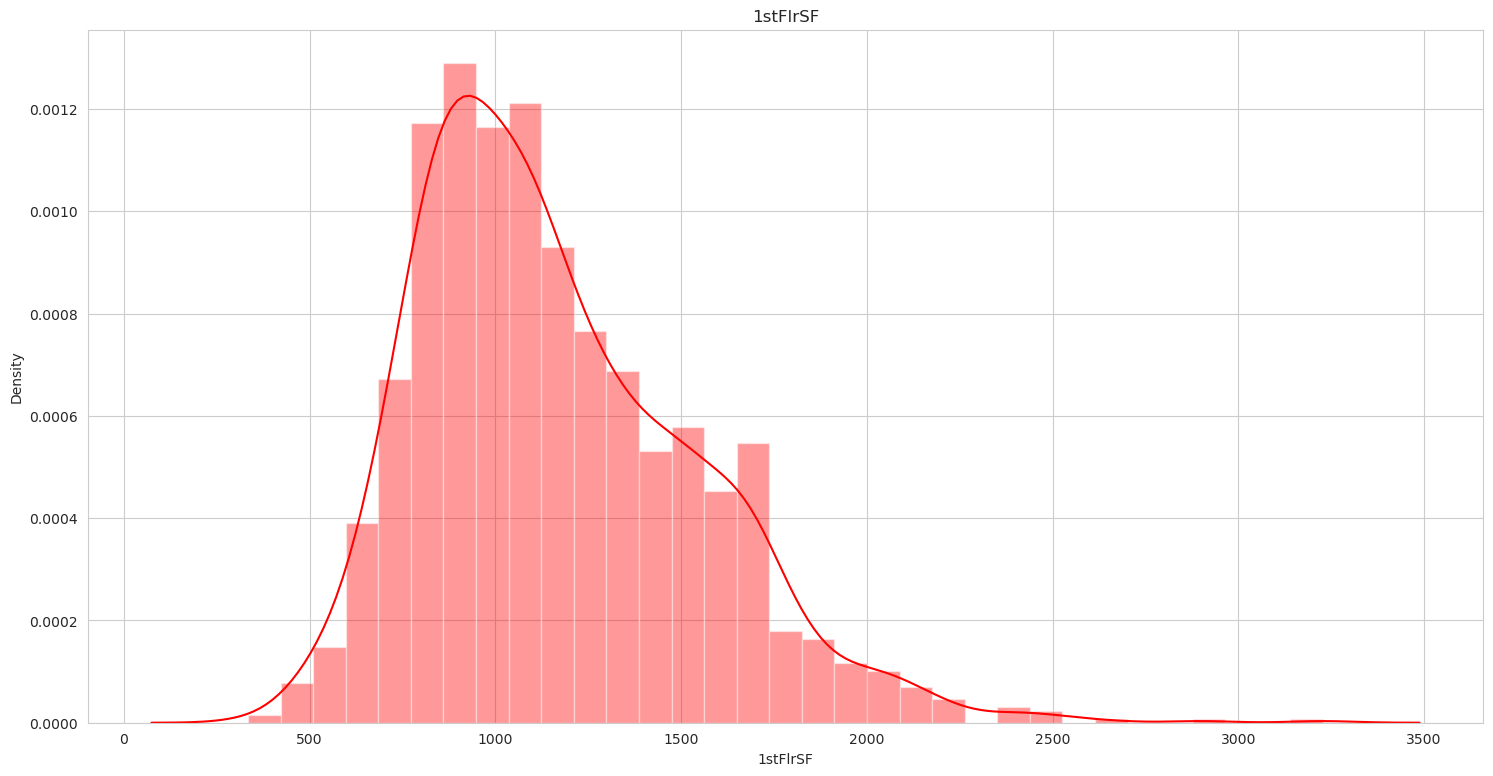

In [17]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['1stFlrSF'], color="red")
ax.set(xlabel="1stFlrSF")
ax.set(title="1stFlrSF")
plt.show()

#### **The distribution of the 1stFlrSF feature seems not like Normal Distribution. To convert the distribution of the 1stFlrSF Feature to Normal Distribution, np.log1p transformation function in numpy was applied**

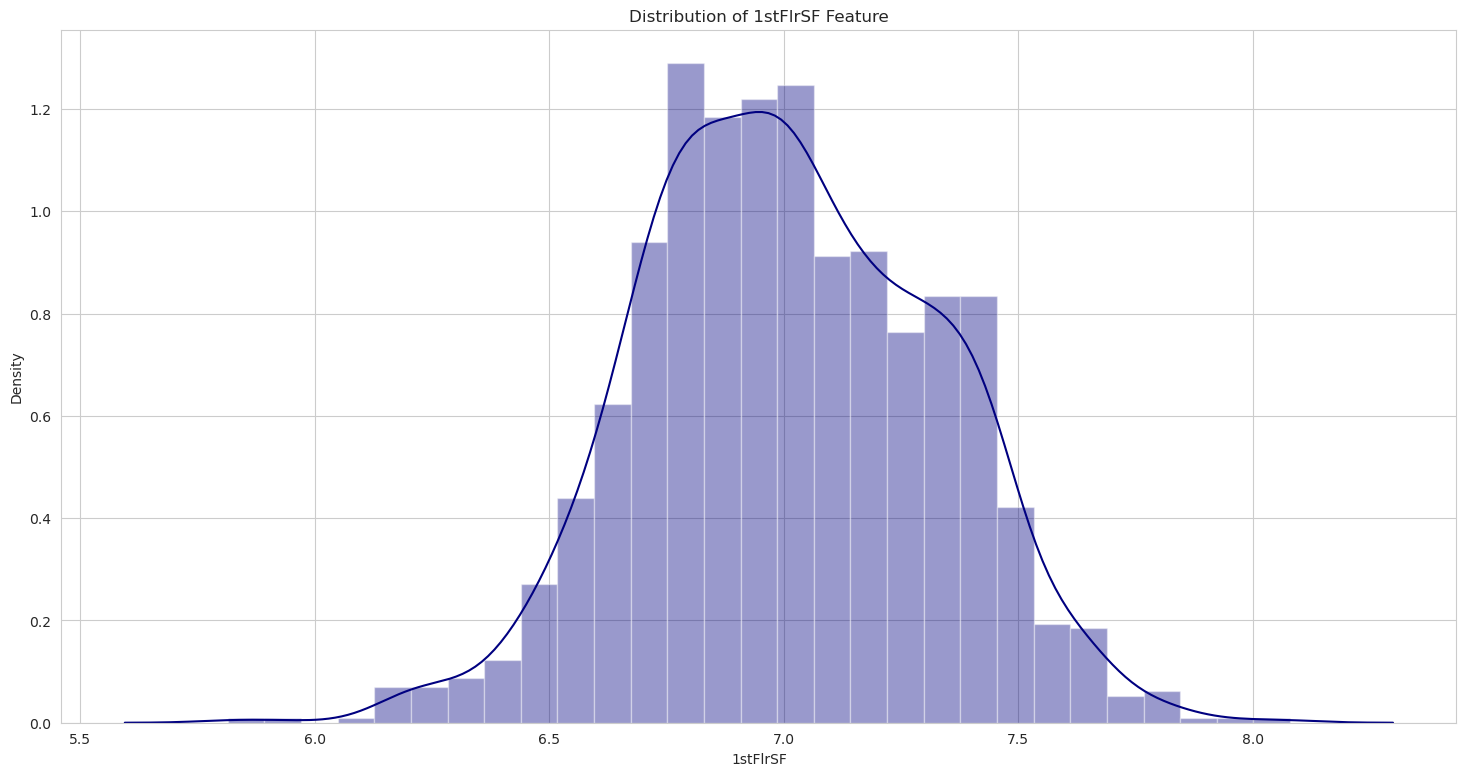

In [18]:
train['1stFlrSF'] = np.log1p(train['1stFlrSF'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['1stFlrSF'], color="navy")
ax.set(xlabel="1stFlrSF")
ax.set(title="Distribution of 1stFlrSF Feature")
plt.show()

#### **Now the distribution of the 1stFlrSF feature is much more fitted for Normal Distribution**

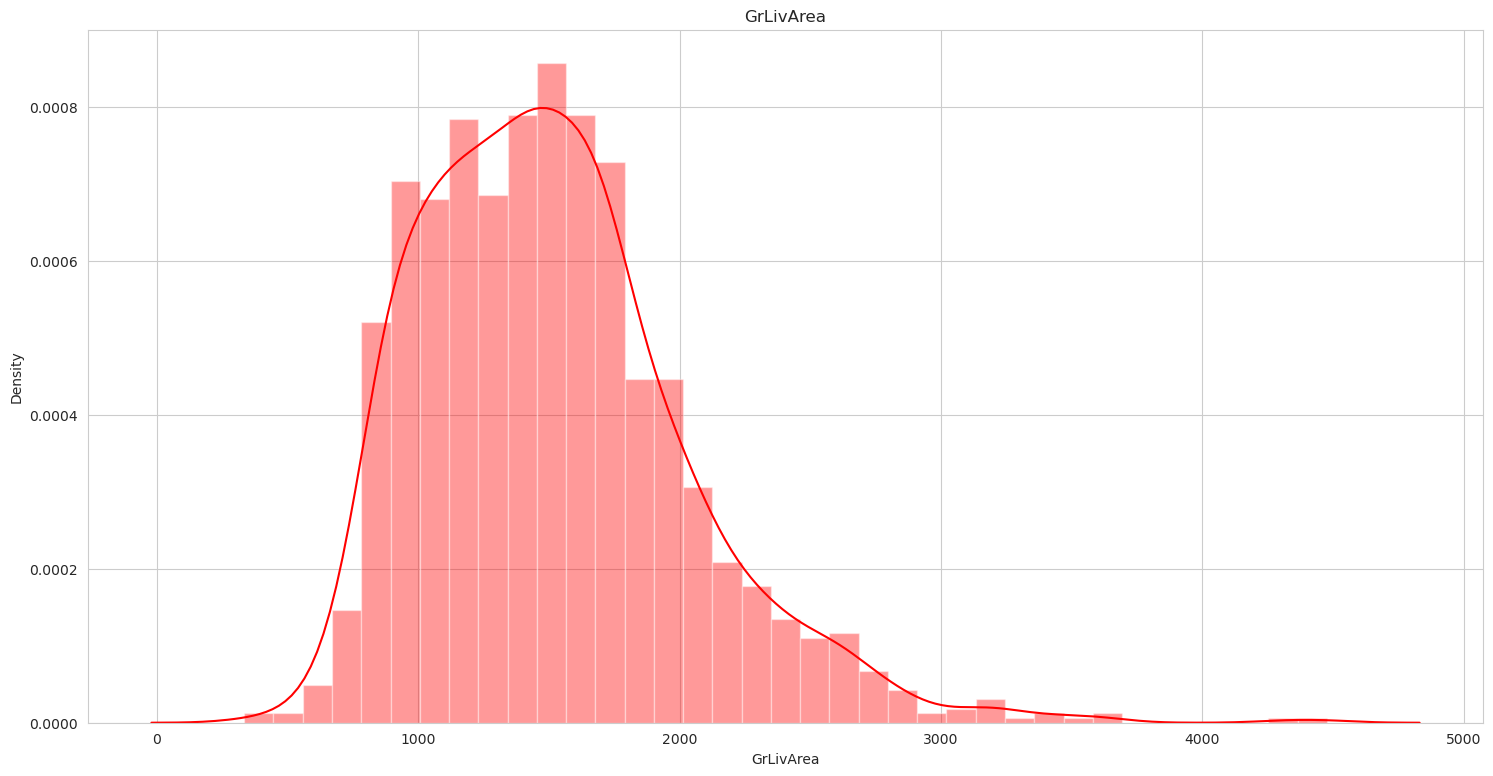

In [19]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['GrLivArea'], color="red")
ax.set(xlabel="GrLivArea")
ax.set(title="GrLivArea")
plt.show()

#### **The distribution of the GrLivArea feature seems not like Normal Distribution. To convert the distribution of the GrLivArea Feature to Normal Distribution, np.log1p transformation function in numpy was applied**

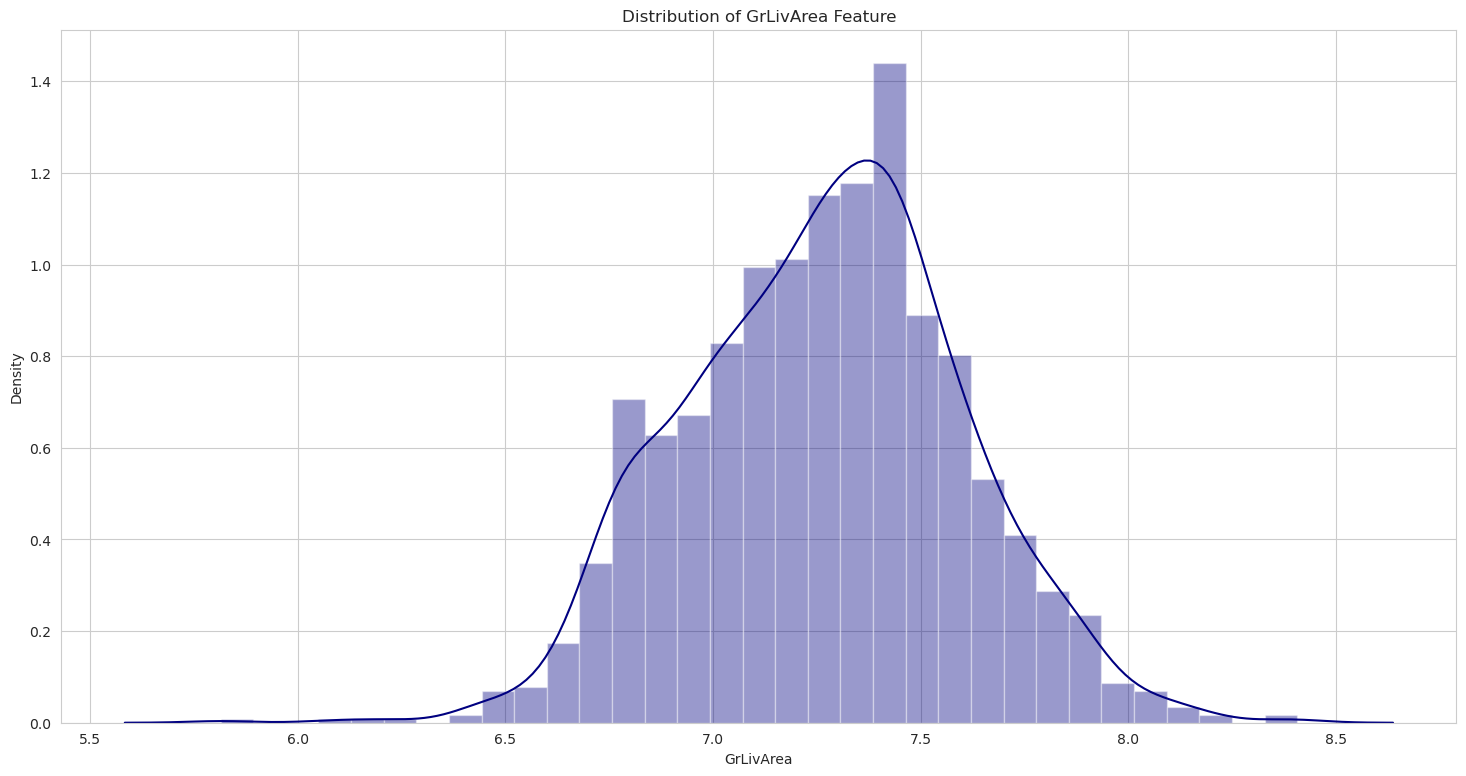

In [20]:
train['GrLivArea'] = np.log1p(train['GrLivArea'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['GrLivArea'], color="navy")
ax.set(xlabel="GrLivArea")
ax.set(title="Distribution of GrLivArea Feature")
plt.show()

#### **Now the distribution of the GrLivArea feature is much more fitted for Normal Distribution**

In [21]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
df_new = pd.concat((train, test)).reset_index(drop=True)
df_new.drop(['SalePrice'], axis=1, inplace=True)

## HANDLING MISSING VALUES

In [22]:
df_new.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64

<AxesSubplot:>

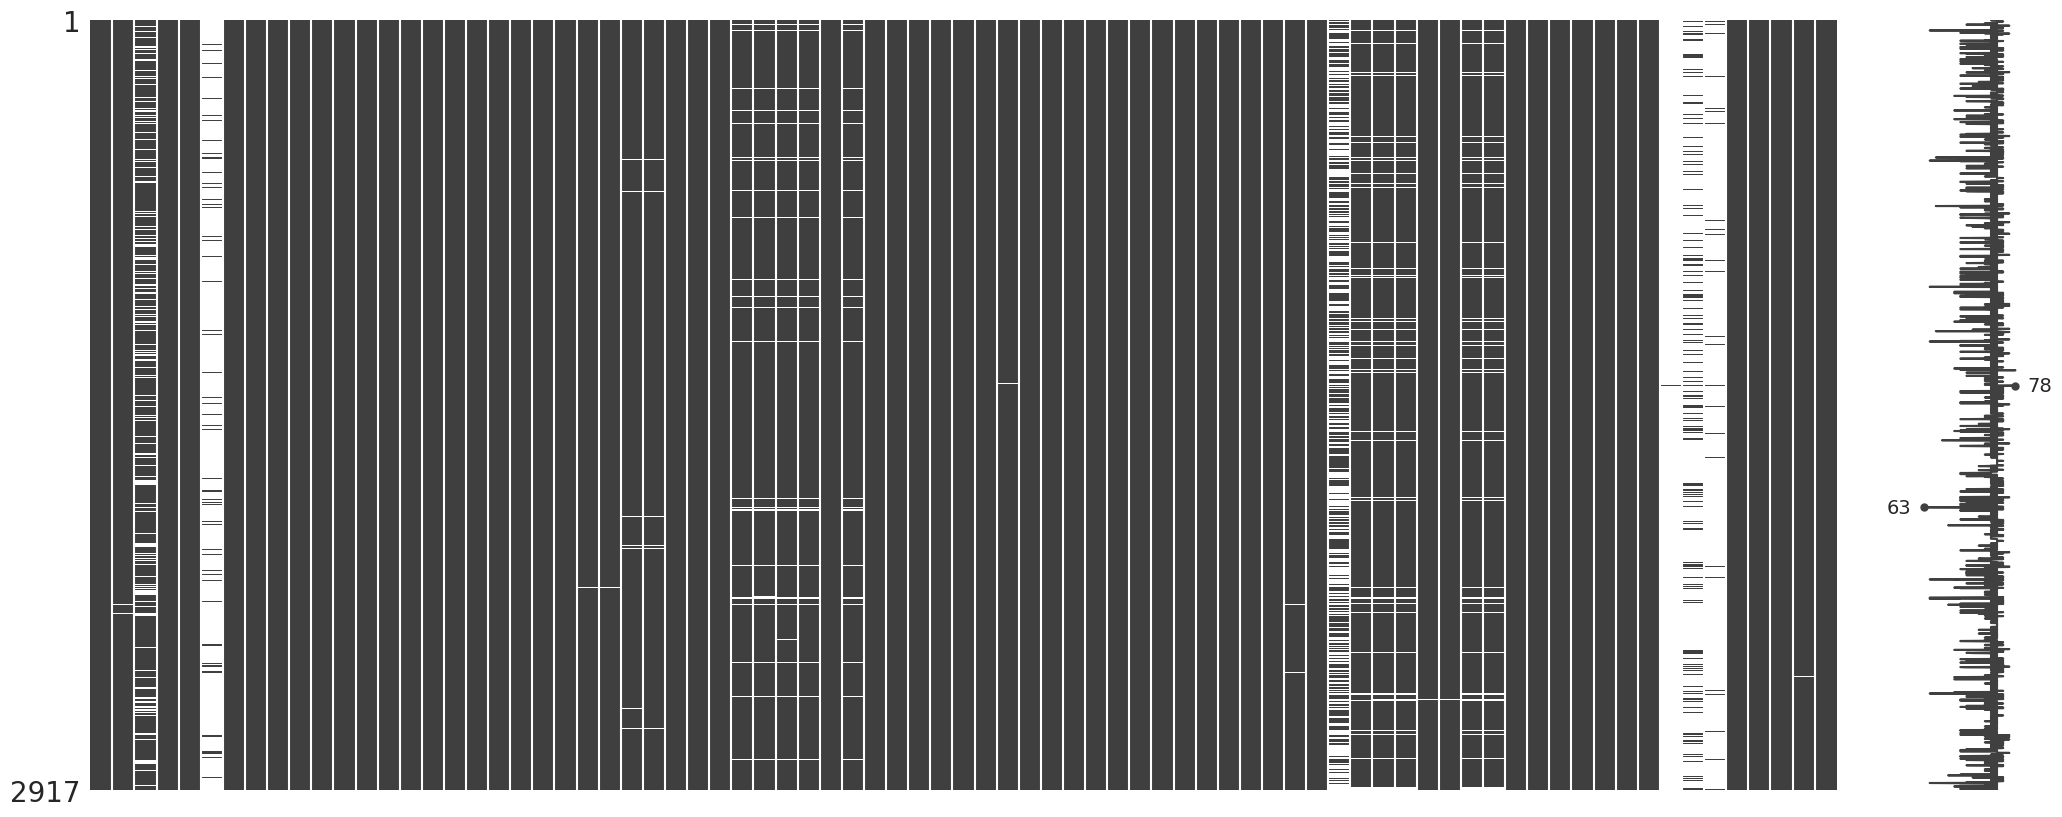

In [23]:
msno.matrix(df_new)

In [24]:
df_new["PoolQC"] = df_new["PoolQC"].fillna("Not Available")
df_new["MiscFeature"] = df_new["MiscFeature"].fillna("Not Available")
df_new["Alley"] = df_new["Alley"].fillna("Not Available")
df_new["FireplaceQu"] = df_new["FireplaceQu"].fillna("Not Available")
df_new["LotFrontage"] = df_new.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_new["MasVnrType"] = df_new["MasVnrType"].fillna("Not Available")
df_new["Fence"] = df_new["Fence"].fillna("Not Available")
df_new['SaleType'] = df_new['SaleType'].fillna(df_new['SaleType'].mode()[0])
df_new['MSSubClass'] = df_new['MSSubClass'].fillna("Not Available")
df_new = df_new.drop(['Utilities'], axis=1)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_new[col] = df_new[col].fillna('Not Available')
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_new[col] = df_new[col].fillna('Not Available')

In [25]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_new[col] = df_new[col].fillna(0)

In [26]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_new[col] = df_new[col].fillna(0)

In [27]:
df_new["MasVnrArea"] = df_new["MasVnrArea"].fillna(0)

In [28]:
df_new['MSZoning'] = df_new['MSZoning'].fillna(df_new['MSZoning'].mode()[0])
df_new["Functional"] = df_new["Functional"].fillna("Typ")
df_new['Electrical'] = df_new['Electrical'].fillna(df_new['Electrical'].mode()[0])
df_new['KitchenQual'] = df_new['KitchenQual'].fillna(df_new['KitchenQual'].mode()[0])
df_new['Exterior1st'] = df_new['Exterior1st'].fillna(df_new['Exterior1st'].mode()[0])
df_new['Exterior2nd'] = df_new['Exterior2nd'].fillna(df_new['Exterior2nd'].mode()[0])

## FEATURE ENGINEERING

In [29]:
df_new['MSSubClass'] = df_new['MSSubClass'].apply(str)
df_new['OverallCond'] = df_new['OverallCond'].astype(str)
df_new['YrSold'] = df_new['YrSold'].astype(str)
df_new['MoSold'] = df_new['MoSold'].astype(str)

In [30]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

le = LabelEncoder()

for i in cols:
    df_new[i] = le.fit_transform(df_new[[i]])

In [31]:
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index

skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for i in skewed_features:
    df_new[i] = boxcox1p(df_new[i], lam)


Skew in numerical features: 

There are 58 skewed numerical features to Box Cox transform


In [32]:
df_new = pd.get_dummies(df_new)
print(df_new.shape)
train = df_new[:ntrain]
test = df_new[ntrain:]
print(train.shape)
print(test.shape)

(2917, 220)
(1458, 220)
(1459, 220)


## REGRESSION MODELS

In [33]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42) 

In [34]:
xgbr = XGBRegressor(learning_rate=0.01,
                       n_estimators=8000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [35]:
lgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=6000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [36]:
rfr = RandomForestRegressor(n_estimators=7000,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [37]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 123).get_n_splits(train.values)

In [38]:
gbr_mse_cv_scores = - cross_val_score(gbr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
gbr_rmse_score = np.sqrt(gbr_mse_cv_scores)

xgbr_mse_cv_scores = - cross_val_score(xgbr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
xgbr_rmse_score = np.sqrt(xgbr_mse_cv_scores)

lgbm_mse_cv_scores = - cross_val_score(lgbm, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
lgbm_rmse_score = np.sqrt(lgbm_mse_cv_scores)

rfr_mse_cv_scores = - cross_val_score(rfr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
rfr_rmse_score = np.sqrt(rfr_mse_cv_scores)

print('Gradient Boosting Regressor CV RMSE Score :', gbr_rmse_score.mean())
print('XGBoost Regressor CV RMSE Score :', xgbr_rmse_score.mean())
print('LightGBM Regressor CV RMSE Score :', lgbm_rmse_score.mean())
print('Random Forest Regressor CV RMSE Score :', rfr_rmse_score.mean())

Gradient Boosting Regressor CV RMSE Score : 0.1137424237544542
XGBoost Regressor CV RMSE Score : 0.1375902274502338
LightGBM Regressor CV RMSE Score : 0.11686110936964751
Random Forest Regressor CV RMSE Score : 0.14154688339904703


In [39]:
gbr.fit(train, y_train)
gbr_train_pred = gbr.predict(train)
gbr_pred = np.expm1(gbr.predict(test.values))
rmse_gbr = np.sqrt(mean_squared_error(y_train,gbr_train_pred))
print(rmse_gbr)

0.06469491677591571


In [40]:
xgbr.fit(train,y_train)
xgbr_train_pred = xgbr.predict(train)
xgbr_pred = np.expm1(xgbr.predict(test.values))
rmse_xgbr = np.sqrt(mean_squared_error(y_train,xgbr_train_pred))
print(rmse_xgbr)

0.11807510753141792


In [41]:
lgbm.fit(train, y_train)
lgbm_train_pred = lgbm.predict(train)
lgbm_pred = np.expm1(lgbm.predict(test.values))
rmse_lgbm = np.sqrt(mean_squared_error(y_train,lgbm_train_pred))
print(rmse_lgbm)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.05579056343914016


In [42]:
rfr.fit(train, y_train)
rfr_train_pred = rfr.predict(train)
rfr_pred = np.expm1(rfr.predict(test.values))
rmse_rfr = np.sqrt(mean_squared_error(y_train,rfr_train_pred))
print(rmse_rfr)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] baggi

In [43]:
models = ['Gradient Boosting', 'XGBoost', 'LightGBM', 'Random Forest']

rmse_scores = [rmse_gbr, rmse_xgbr, rmse_lgbm, rmse_rfr]

model_scores = pd.DataFrame({
    
    'Regression Models' : models,
    'RMSE Scores' : rmse_scores
    
})

results = model_scores.sort_values('RMSE Scores', ascending = True, ignore_index= True)
results

,Regression Models,RMSE Scores
0,LightGBM,0.056
1,Gradient Boosting,0.065
2,Random Forest,0.088
3,XGBoost,0.118


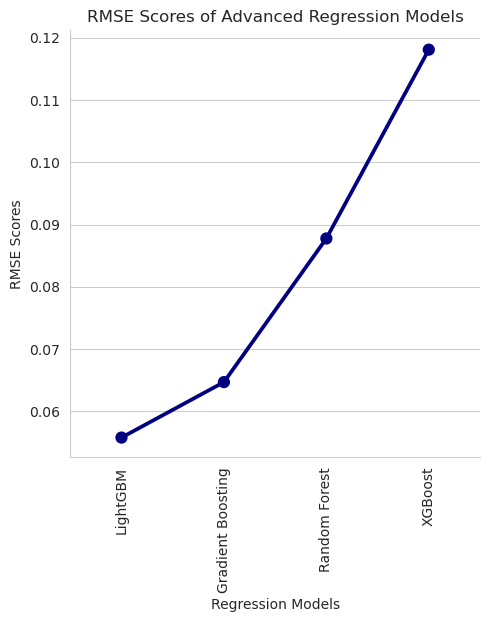

In [44]:
sns.catplot(x = 'Regression Models', y = 'RMSE Scores', order = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost'],
           data = results, kind='point', color = 'Navy')
plt.title('RMSE Scores of Advanced Regression Models')
plt.xticks(rotation = 90)
plt.show()

In [45]:
results.to_csv('final_submission.csv', index = 'None')

## CONCLUSION

**Based on the modelling with advanced regression algorithms, LightGBM seems to have the minimum RMSE score which makes it the best for predictions in this dataset.**